In [1]:
import json
import os
import numpy as np
import tensorflow as tf
from pathlib2 import Path
import preprocess
from data_loader import create_dataset, create_inputs

2021-12-03 17:41:01.444931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 17:41:01.444959: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def prepare_data(data_dir, language):
    if language == "Chinese":
        train_path = data_dir / "train_cn.json"
        test_path = data_dir / "test_cn.json"
        dev_path = data_dir / "dev_cn.json"

    elif language == "English":
        train_path = data_dir / "train_en.json"
        test_path = data_dir / "test_en.json"
        dev_path = data_dir / "dev_en.json"

    else:
        raise ValueError("Language must be English or Chinese")

    if not os.path.isfile(test_path):
        test_path = None

    return train_path, dev_path, test_path

data_dir = "./dataset"
language = "Chinese"
train_path, dev_path, test_path = prepare_data(data_dir=Path(data_dir), language=language)
train_path, dev_path, test_path

(PosixPath('dataset/train_cn.json'), PosixPath('dataset/dev_cn.json'), None)

In [3]:
data  = create_inputs(json_path=train_path, plm="BERT",
                                                max_len=512,
                                                is_train=True, language="Chinese", task="nugget")
dataset = create_dataset(data, "nugget")
a = list(dataset.take(1))

2021-12-03 17:41:05.099977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-03 17:41:05.100031: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 17:41:05.100045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-EFG9I9T): /proc/driver/nvidia/version does not exist
2021-12-03 17:41:05.101921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from model import create_dialogue_model
model = create_dialogue_model(plm_name="BERT", language="Chinese", max_turn_number=7, layer_num=1)

Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(None, 7)
Tensor("custom_softmax_1/count_nonzero/Sum:0", shape=(None,), dtype=int64) Tensor("custom_softmax_1/count_nonzero_1/Sum:0", shape=(None,), dtype=int64)


/home/laurence/.local/share/virtualenvs/Dialogue-JGwhu-Cj/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
model.summary()

Model: "dialogue nugget"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 sentence_ids (InputLayer)      [(None, 7)]          0           []                               
                                                                                    

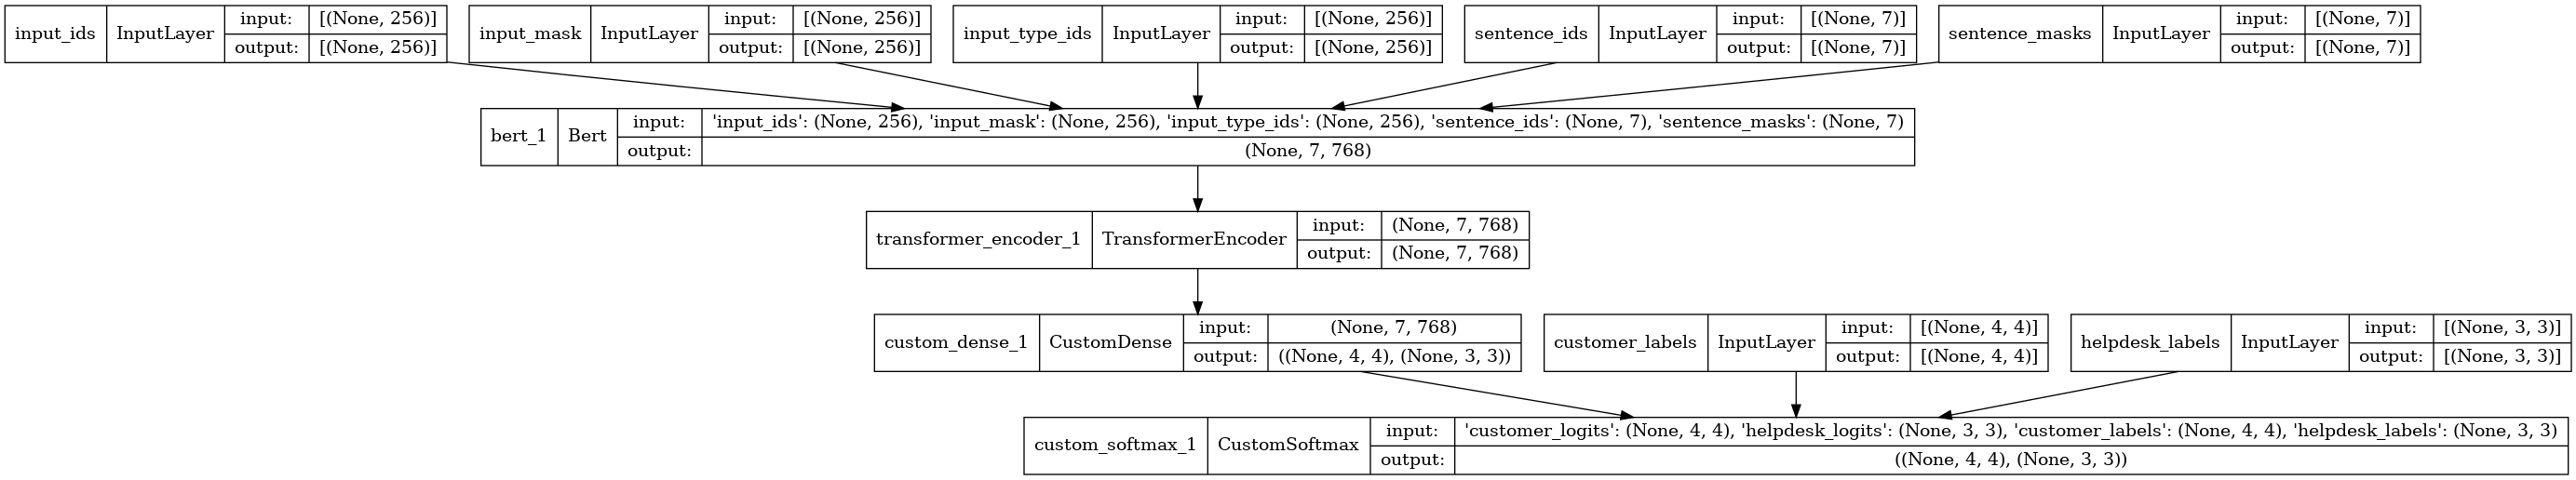

In [11]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [12]:
ckpt_path = "./checkpoint/"

In [13]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=1, monitor="val_rnss", save_best_only=True, mode="max")

In [ ]:
data2  = create_inputs(json_path=dev_path, plm="BERT",
                                                max_len=512,
                                                is_train=True, language="Chinese", task="nugget")
val_dataset = create_dataset(data2, "nugget", 10000)

In [ ]:
history = model.fit(x=dataset, epochs=3, verbose="auto",
                                                   callbacks=callback, validation_data=val_dataset, 
                    steps_per_epoch=128)